In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Constants.


In [2]:
# Global constants for problems
ROSENBROCK_BOUNDS = [-2.048, 2.048]
RASTRIGIN_BOUNDS = [-5.12, 5.12]
PC_BINARY = 0.9  # Crossover probability for binary encoding
PC_REAL = 0.9  # Crossover probability for real encoding
PM_BINARY = 1 / 16  # Mutation probability for binary encoding
PM_REAL = 1 / 16  # Mutation probability for real encoding
N_C = 20  # Distribution index for SBX crossover
N_P = 20  # Mutation parameter

# Target functions.

In [3]:
# Target functions for fitness evaluation
def rosenbrock(x):
  return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rastrigin(x, A=10):
  return A * len(x) + sum(xi**2 - A * np.cos(2 * np.pi * xi) for xi in x)

# Encoding.

In [4]:
# Helper functions for binary encoding/decoding
def real_to_binary(real_value, bounds, n_bits):
  """Convert a real value within bounds to a binary representation."""
  scaled_value = (real_value - bounds[0]) / (bounds[1] - bounds[0])  # Scale to [0, 1]
  max_int = 2**n_bits - 1
  int_value = int(scaled_value * max_int)
  binary_str = np.binary_repr(int_value, width=n_bits)  # Get binary string with fixed width
  return np.array([int(bit) for bit in binary_str])  # Convert to array of binary digits

def binary_to_real(binary_chrom, bounds):
  """Convert binary chromosome to real value within the bounds."""
  decimal_value = int("".join(map(str, binary_chrom)), 2)
  max_decimal = 2**len(binary_chrom) - 1
  real_value = bounds[0] + (bounds[1] - bounds[0]) * (decimal_value / max_decimal)
  return real_value

# Crossover.


In [5]:
# Binary encoding crossover and mutation
def single_point_crossover(p1, p2):
  point = np.random.randint(1, len(p1))
  child1 = np.concatenate((p1[:point], p2[point:]))
  child2 = np.concatenate((p2[:point], p1[point:]))
  return child1, child2

# Real encoding crossover (SBX) and mutation
def sbx_crossover(p1, p2, nc):
  child1, child2 = np.zeros_like(p1), np.zeros_like(p2)
  for i in range(len(p1)):
    u = np.random.rand()
    if u <= 0.5:
      beta = (2 * u)**(1 / (nc + 1))
    else:
      beta = (1 / (2 * (1 - u)))**(1 / (nc + 1))
    child1[i] = 0.5 * ((1 + beta) * p1[i] + (1 - beta) * p2[i])
    child2[i] = 0.5 * ((1 - beta) * p1[i] + (1 + beta) * p2[i])
  return child1, child2

# Mutation.


In [6]:
def binary_mutation(chrom, Pm):
  for i in range(len(chrom)):
    if np.random.rand() < Pm:
      chrom[i] = 1 - chrom[i]  # Flip the bit
  return chrom

def pm_mutation(chrom, bounds, gen):
  for i in range(len(chrom)):
    if np.random.rand() < PM_REAL:
      delta = abs(min(chrom[i] - bounds[0], bounds[1] - chrom[i]) / (bounds[0] - bounds[1]))
      nm = 100 + gen
      delta_q = 0
      eps = 1e-8
      if delta < 0.5:
        delta_q = (2 * delta + eps)**(1 / (nm + 1)) - 1
      else:
        delta_q = 1 - (2 * (1 - delta + eps))**(1 / (nm + 1))
      chrom[i] += delta_q * (bounds[1] - bounds[0])
      chrom[i] = np.clip(chrom[i], bounds[0], bounds[1])
  return chrom

# Selection.


In [7]:
def roulette_wheel_selection(population, fitness):
    # Transform fitness for minimization (shift and scale to make small values more likely)
    max_fitness = max(fitness)
    min_fitness = min(fitness)
    
    # Ensure that fitness values are positive and smaller fitness values are weighted higher
    transformed_fitness = [max_fitness - f + 1e-6 for f in fitness]  # Add a small value to avoid zero fitness

    # Compute cumulative probability for roulette selection
    total_fitness = sum(transformed_fitness)
    probabilities = [f / total_fitness for f in transformed_fitness]
    cumulative_probabilities = np.cumsum(probabilities)

    # Obtain a random number in [0, 1]
    r = np.random.rand()

    # Select the individual based on the random number and cumulative probabilities
    for i, cum_prob in enumerate(cumulative_probabilities):
        if r <= cum_prob:
            return population[i]
    
    return population[-1]  # Fallback in case of rounding error


In [8]:
def binary_tournament_selection(population, fitness):
    population_copy = population[:]  # Create a copy of the population to manipulate
    fitness_copy = fitness[:]        # Copy fitness array to manipulate
    
    while len(population_copy) > 1:
        winner_arr = []
        
        # Perform selection in pairs
        while len(population_copy) >= 2:
            # Randomly select two individuals
            first_idx, second_idx = np.random.choice(len(population_copy), size=2, replace=False)
            
            first_individual = population_copy[first_idx]
            second_individual = population_copy[second_idx]
            
            # Compare their fitness and select the winner
            if fitness_copy[first_idx] < fitness_copy[second_idx]:
                winner_arr.append(first_individual)
            else:
                winner_arr.append(second_individual)
            
            # Remove both individuals from the population
            del population_copy[max(first_idx, second_idx)]
            del fitness_copy[max(first_idx, second_idx)]
            del population_copy[min(first_idx, second_idx)]
            del fitness_copy[min(first_idx, second_idx)]

        # If odd number of individuals, automatically advance the last individual
        if len(population_copy) == 1:
            winner_arr.append(population_copy[0])
        
        # Set the population for the next round
        population_copy = winner_arr
        fitness_copy = [fitness[i] for i in range(len(population_copy))]

    # Return the last remaining winner
    return population_copy[0]

# Genetic Algorithm.


In [9]:
# Genetic Algorithm framework
def genetic_algorithm(fitness_function, bounds, encoding_type="binary", n_generations=100, pop_size=100, n_bits=16, stop_threshold=1e-6, stagnation_generations=5, verbose=False):
    # Create initial population as real values
    population = [np.random.uniform(bounds[0], bounds[1], 2) for _ in range(pop_size)]

    if encoding_type == "binary":
        # Convert real values to binary representations
        population = [real_to_binary(ind[0], bounds, n_bits) for ind in population]

    best_fitness_per_gen = []
    stagnation_count = 0

    for gen in range(n_generations):
        if encoding_type == "binary":
            # Convert binary population to real values for fitness evaluation
            real_population = [binary_to_real(ind, bounds) for ind in population]
            fitness = [fitness_function([val]) for val in real_population]
        else:
            fitness = [fitness_function(ind) for ind in population]

        if encoding_type == "binary":
            new_population = []
            for _ in range(pop_size // 2):
                p1 = roulette_wheel_selection(population, fitness)
                p2 = roulette_wheel_selection(population, fitness)
                if np.random.rand() < PC_BINARY:
                    c1, c2 = single_point_crossover(p1, p2)
                else:
                    c1, c2 = p1, p2
                c1 = binary_mutation(c1, PM_BINARY)
                c2 = binary_mutation(c2, PM_BINARY)
                new_population.extend([c1, c2])
            population = new_population
        else:
            new_population = []
            for _ in range(pop_size // 2):
                p1 = binary_tournament_selection(population, fitness)
                p2 = binary_tournament_selection(population, fitness)
                if np.random.rand() < PC_REAL:
                    c1, c2 = sbx_crossover(p1, p2, N_C)
                else:
                    c1, c2 = p1, p2
                c1 = pm_mutation(c1, bounds, gen)
                c2 = pm_mutation(c2, bounds, gen)
                new_population.extend([c1, c2])
            population = new_population

        # Track best fitness
        best_fitness = min(fitness)
        best_fitness_per_gen.append(best_fitness)

        if verbose:
            print(f"Generation {gen + 1}, Best Fitness: {best_fitness}")

        # Check for stagnation (early stopping)
        if gen >= stagnation_generations:
            recent_fitness = best_fitness_per_gen[-stagnation_generations:]
            fitness_change = max(recent_fitness) - min(recent_fitness)

            if fitness_change < stop_threshold:
                print(f"Early stopping at generation {gen + 1} due to insufficient improvement.")
                break

    return best_fitness_per_gen

# Testing the algorithm

Generation 1, Best Fitness: 0.22261088428232628
Generation 2, Best Fitness: 0.48005524614495226
Generation 3, Best Fitness: 0.03732215461158549
Generation 4, Best Fitness: 0.040067983911770313
Generation 5, Best Fitness: 0.03976694924298438
Generation 6, Best Fitness: 0.02737208048719429
Generation 7, Best Fitness: 0.02761831622673346
Generation 8, Best Fitness: 0.027377318626324355
Generation 9, Best Fitness: 0.0273280069931926
Generation 10, Best Fitness: 0.021881193633672327
Generation 11, Best Fitness: 0.027094677085287976
Generation 12, Best Fitness: 0.011874282118737403
Generation 13, Best Fitness: 0.011874282118737403
Generation 14, Best Fitness: 0.01766601901968113
Generation 15, Best Fitness: 0.013428457416300055
Generation 16, Best Fitness: 0.013433699593522965
Generation 17, Best Fitness: 0.01740309434141068
Generation 18, Best Fitness: 0.014896324876751315
Generation 19, Best Fitness: 0.023647060199324818
Generation 20, Best Fitness: 0.025519731809914046
Generation 21, Best

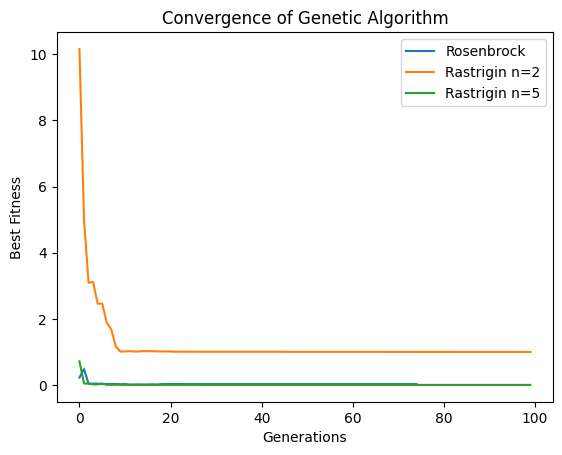

In [10]:
# Run for Rosenbrock (Test problem 1)
best_fitness_rosenbrock = genetic_algorithm(rosenbrock, ROSENBROCK_BOUNDS, "real", verbose=True)

# Run for Rastrigin n=2 and n=5
best_fitness_rastrigin_2 = genetic_algorithm(lambda x: rastrigin(x, A=10), RASTRIGIN_BOUNDS, "real", verbose=True)
best_fitness_rastrigin_5 = genetic_algorithm(lambda x: rastrigin(x, A=10), RASTRIGIN_BOUNDS, "real", verbose=True)

# Plot convergence graph
plt.plot(best_fitness_rosenbrock, label="Rosenbrock")
plt.plot(best_fitness_rastrigin_2, label="Rastrigin n=2")
plt.plot(best_fitness_rastrigin_5, label="Rastrigin n=5")
plt.title("Convergence of Genetic Algorithm")
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.legend()
plt.show()

In [36]:


# Problems and parameters
problems = {
    'Rastrigin n=1': rastrigin,  # For binary encoding
    'Test Problem 1': rosenbrock,   # Only for real encoding
    'Rastrigin n=2': rastrigin,     # Only for real encoding
    'Rastrigin n=5': rastrigin      # Only for real encoding
}

bounds = {
    'Rastrigin n=1': RASTRIGIN_BOUNDS,
    'Test Problem 1': ROSENBROCK_BOUNDS,
    'Rastrigin n=2': RASTRIGIN_BOUNDS,
    'Rastrigin n=5': RASTRIGIN_BOUNDS
}

dimensions = {
    'Rastrigin n=1': 1,
    'Test Problem 1': 2,
    'Rastrigin n=2': 2,
    'Rastrigin n=5': 5
}

encoding_types = ['binary', 'real']

# Experiment parameters
n_experiments = 20
n_generations = 100
pop_size = 100
n_bits = 16

# Initialize the results dictionary
results = {}

# Run experiments for each problem and encoding type
for problem_name in problems:
    fitness_function = problems[problem_name]
    bound = bounds[problem_name]
    dim = dimensions[problem_name]
    results[problem_name] = {}
    for encoding in encoding_types:
        # Skip incompatible combinations (binary encoding with multi-dimensional problems)
        if encoding == 'binary' and dim > 1:
            continue
        all_best_fitness = []
        all_convergence = []
        for exp in range(n_experiments):
            print(f"Running {problem_name}, Encoding: {encoding}, Experiment: {exp + 1}")
            best_fitness_per_gen = genetic_algorithm(
                fitness_function=fitness_function,
                bounds=bound,
                encoding_type=encoding,
                n_generations=n_generations,
                pop_size=pop_size,
                n_bits=n_bits,
                stop_threshold=1e-6,
                stagnation_generations=5,
                verbose=False
            )
            # Collect best fitness of the last generation
            all_best_fitness.append(best_fitness_per_gen[-1])
            # Collect convergence data (best fitness per generation)
            all_convergence.append(best_fitness_per_gen)
        # Store results
        results[problem_name][encoding] = {
            'best_fitness': all_best_fitness,
            'convergence': all_convergence
        }

# Build the results table
table_data = {}
for problem_name in problems:
    dim = dimensions[problem_name]
    for encoding in encoding_types:
        # Skip incompatible combinations
        if encoding == 'binary' and dim > 1:
            continue
        key = f"{problem_name} ({encoding} encoding)"
        best_fitness_list = results[problem_name][encoding]['best_fitness']
        table_data[key] = best_fitness_list

# Create DataFrame from the collected data



Running Rastrigin n=1, Encoding: binary, Experiment: 1
Running Rastrigin n=1, Encoding: binary, Experiment: 2
Running Rastrigin n=1, Encoding: binary, Experiment: 3
Running Rastrigin n=1, Encoding: binary, Experiment: 4
Running Rastrigin n=1, Encoding: binary, Experiment: 5
Running Rastrigin n=1, Encoding: binary, Experiment: 6
Running Rastrigin n=1, Encoding: binary, Experiment: 7
Running Rastrigin n=1, Encoding: binary, Experiment: 8
Running Rastrigin n=1, Encoding: binary, Experiment: 9
Running Rastrigin n=1, Encoding: binary, Experiment: 10
Running Rastrigin n=1, Encoding: binary, Experiment: 11
Running Rastrigin n=1, Encoding: binary, Experiment: 12
Running Rastrigin n=1, Encoding: binary, Experiment: 13
Running Rastrigin n=1, Encoding: binary, Experiment: 14
Running Rastrigin n=1, Encoding: binary, Experiment: 15
Running Rastrigin n=1, Encoding: binary, Experiment: 16
Running Rastrigin n=1, Encoding: binary, Experiment: 17
Running Rastrigin n=1, Encoding: binary, Experiment: 18
R

IndexError: list index out of range

In [14]:
df = pd.DataFrame(table_data)
df.index = [f"Experiment {i + 1}" for i in range(n_experiments)]

# Calculate statistics
stats = df.describe().loc[['mean', 'std', 'min', 'max']]
stats.index = ['Mean', 'Standard Deviation', 'Min', 'Max']
df = pd.concat([df, stats])
df.to_csv('results.csv')
# Display the results table
print("\nFinal Results Table:")





Final Results Table:


In [15]:
df

,Rastrigin n=1 (binary encoding),Rastrigin n=1 (real encoding),Test Problem 1 (real encoding),Rastrigin n=2 (real encoding),Rastrigin n=5 (real encoding)
Experiment 1,0.050846,0.995465,3.912022e-03,0.996942,1.342421
Experiment 2,0.027598,0.003188,5.428605e-02,1.013293,1.015897
Experiment 3,0.999651,0.003630,2.514735e-04,0.995096,3.980021
Experiment 4,0.002035,1.989918,2.068945e-05,1.989932,0.999416
Experiment 5,0.319470,0.996093,4.938447e-03,1.990414,0.100749
Experiment 6,0.058022,0.995022,4.538946e-03,0.995132,0.995823
Experiment 7,0.076194,0.995108,1.189999e-03,1.989941,0.995166
Experiment 8,0.392246,1.015178,2.231412e-02,1.990148,0.001663
Experiment 9,0.098198,1.989978,5.746422e-04,0.996420,0.999795
Experiment 10,0.013348,0.998305,3.156582e-01,0.000140,1.989918


In [16]:
dimensions

{'Rastrigin n=1': 1,
 'Test Problem 1': 2,
 'Rastrigin n=2': 2,
 'Rastrigin n=5': 5}


Generating convergence plots for Experiment 12


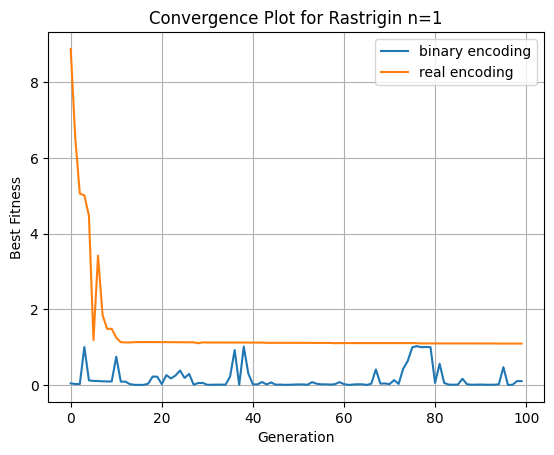

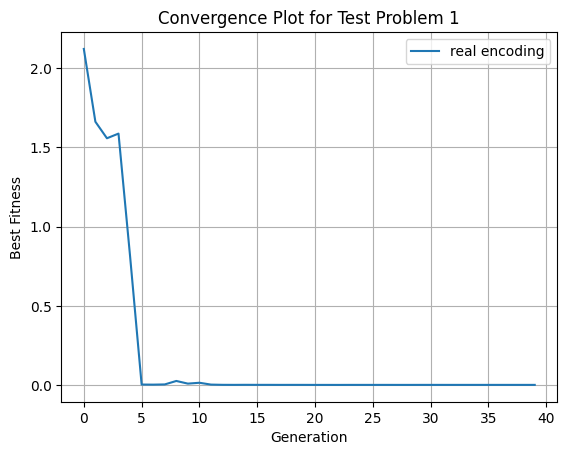

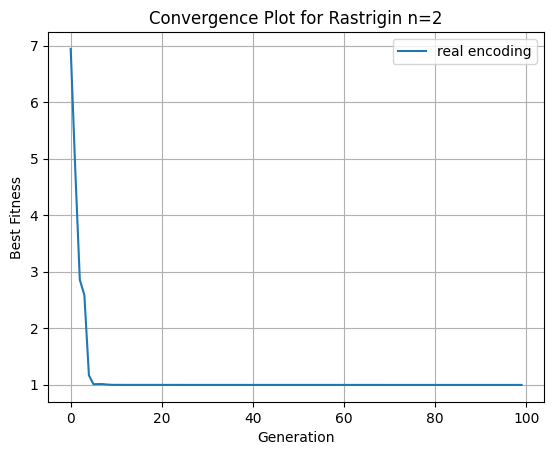

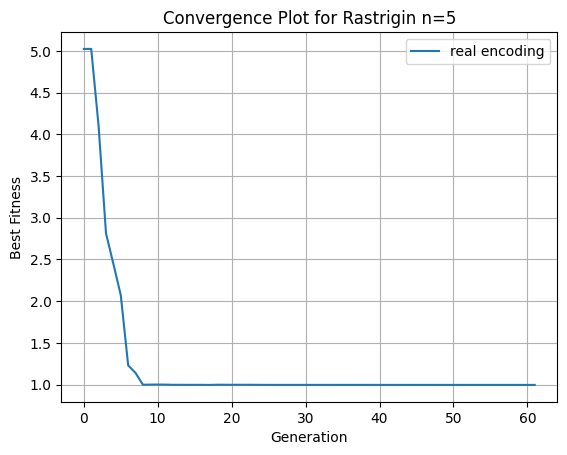

In [35]:
# Generate convergence plots
selected_experiment = np.random.randint(0, n_experiments)  # Randomly select an experiment

print(f"\nGenerating convergence plots for Experiment {selected_experiment + 1}")

for problem_name in problems:
    plt.figure()
    for encoding in encoding_types:
        # Skip incompatible combinations
        dim = dimensions[problem_name]
        if encoding == 'binary' and dim > 1:
            continue  # Skip multidimensional problems with binary encoding
        # Retrieve the convergence data for the selected experiment
        convergence = results[problem_name][encoding]['convergence'][selected_experiment]
        plt.plot(convergence, label=f"{encoding} encoding")
    plt.title(f"Convergence Plot for {problem_name}")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()
